In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces


In [3]:
datasets = fetch_olivetti_faces()

X.shape: (400, 4096)
img.shape: (400, 64, 64)
y.shape: (400,)


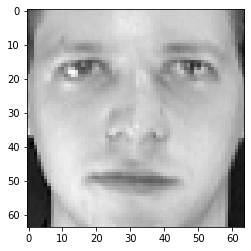

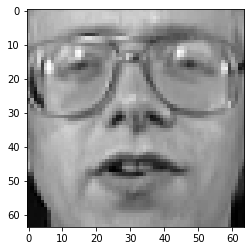

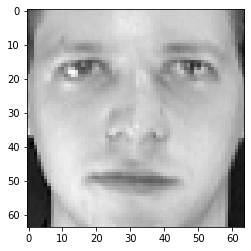

In [4]:
# datasets
X = datasets["data"]
img = datasets["images"]
y = datasets["target"]

print(f"X.shape: {X.shape}")
print(f"img.shape: {img.shape}")
print(f"y.shape: {y.shape}")

def X_to_img(x, show=True):
    reshaped = x.reshape(64, 64)
    if show:
        plt.figure()
        plt.imshow(reshaped, cmap="gray")

plt.imshow(img[0], cmap="gray")
plt.figure()
plt.imshow(img[10], cmap="gray")
X_to_img(X[0])

# KMeans

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify = y)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.2, random_state=42, stratify = y_train)  

print(f"X_train shape: {X_train.shape}")
print(f"X_validation shape: {X_validation.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (256, 4096)
X_validation shape: (64, 4096)
X_test shape: (80, 4096)


Nbr de clusters : 50
inertie : 6286.281325192891
silhouette : 0.16487175226211548


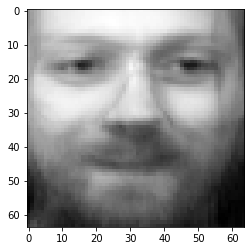

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
k = 50
kmeans = KMeans(n_init=10, n_clusters=k)

kmeans.fit(X_train)
centroides = kmeans.cluster_centers_
inertie = kmeans.inertia_
silhouette = silhouette_score(X_train, kmeans.labels_)



print(f"Nbr de clusters : {centroides.shape[0]}")
print(f"inertie : {inertie}")
print(f"silhouette : {silhouette}")

X_to_img(centroides[0])

In [7]:
# Traçons le graphe de l'inertie en fonction de k. Pareil pour le score de silhouette

list_k = []
list_kmeans = []
list_inertie = []
list_silhouette = []
for k in range(5, 150, 5):
    kmeans = KMeans(n_init=10, n_clusters=k)
    kmeans.fit(X_train)
    list_k.append(k)
    list_kmeans.append(kmeans)

    inertie = kmeans.inertia_
    silhouette = silhouette_score(X_train, kmeans.labels_)
    list_inertie.append(inertie)
    list_silhouette.append(silhouette)


In [85]:
from sklearn.metrics import accuracy_score

best_idx = np.argmax(list_silhouette)
best_kmeans = list_kmeans[np.argmax(list_silhouette)]
best_centroides = best_kmeans.cluster_centers_
plt.figure()
plt.xlabel("k")
plt.subplot(211)
plt.ylabel("inertie")
plt.plot(list_k, list_inertie)
plt.subplot(212)
plt.ylabel("score_silhouette")
plt.plot(list_k, list_silhouette)


(256,)


ValueError: x and y must have same first dimension, but have shapes (29,) and (1,)

In [9]:
# Entrainons un classificateur supervisé sur le jeu de train

from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# On pourrait faire une recherche par quadrillage pour chercher les bons hyper paramètres
randomF = RandomForestClassifier(n_estimators=150, random_state=42)
randomF.fit(X_train, y_train)
score = randomF.score(X_validation, y_validation)
print(f"Précision par le random forest : {score}")


Précision par le random forest : 0.9375


In [50]:
# Nous allons maintenant essayer de réduire la dimension de X avec le Kmeans
# from sklearn.model_selection import GridSearchCV

def randomF_on_kmeans():
    X_kmeans = best_kmeans.transform(X_train)
    randomF = RandomForestClassifier(n_estimators=150, random_state=42)
    randomF.fit(X_kmeans, y_train)
    score = randomF.score(best_kmeans.transform(X_validation), y_validation)
    print(f"Précision par le random forest : {score}")
randomF_on_kmeans()

Précision par le random forest : 0.75


In [55]:
# Nous allons faire une recherche par quadrillage pour avoir le meilleur k

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

params_grid = [
    {
        "kmeans__n_clusters": [100, 110, 120, 130, 140, 150, 160],
    }
]

pipeline = Pipeline([
        ("kmeans", KMeans(random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=150, random_state=42))
    ])

randomForest_search = GridSearchCV(pipeline, cv=5, param_grid=params_grid, refit=True)
randomForest_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=8, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=42, tol=0.0001,
                                               verbose=0)),
                                       ('forest_clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gin...
                                                        

In [57]:
print(f"Best params: {randomForest_search.best_params_}")
print(f"Best score: {randomForest_search.best_score_}")
# Pas très convaincant

Best params: {'kmeans__n_clusters': 120}
Best score: 0.7890625


# Mélanges gaussiens

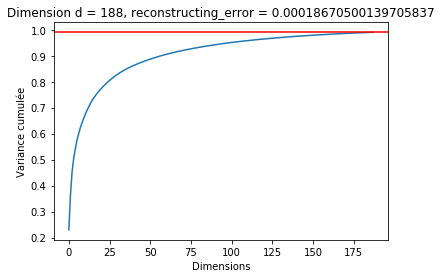

In [14]:
# PCA

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

def reconstructing_error(X_reduced, X_train, pca):
    X_reconstructed = pca.inverse_transform(X_reduced)
    return mean_squared_error(X_reconstructed, X_train)

pca = PCA(n_components=0.99)
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.99) + 1

error = reconstructing_error(pca.transform(X_train), X_train, pca)

plt.figure()
plt.xlabel("Dimensions")
plt.ylabel("Variance cumulée")
plt.title(f"Dimension d = {d}, reconstructing_error = {error}")
plt.plot(cumsum)
plt.axhline(y=0.99, color="r")



In [17]:
X_pca = pca.transform(X_train)

In [18]:
from sklearn.mixture import BayesianGaussianMixture
import time 

bgm =  BayesianGaussianMixture(n_components=50, n_init=10)
start = time.time()
bgm.fit(X_pca)
end = time.time()
print(f"BGM fit on X_train took: {end - start} ms")



BGM fit on X_train took: 6.7700018882751465 ms


In [22]:
print(f"BGM score on X_pca: {bgm.score(X_pca)}")
print(f"BGM score on X_validation_pca: {bgm.score(pca.transform(X_validation))}")
print(f"BGM score on X_test_pca: {bgm.score(pca.transform(X_test))}")
# Apparemment,notre modèle BGM a dû mal à avoir une bonne log-vraisemblance sur les données du jeu de validation et de test. Est-ce un soucis de sur-appprentissage ?

# print(f"BGM cluster weights: {bgm.weights_}")
# print(f"BGM [bic, aic]: {[bgm.bic(X_pca), bgm.aic(X_pca)]}")


BGM score on X_pca: 343.77562079032884
BGM score on X_validation_pca: -8928.522925364341
BGM score on X_test_pca: -8483.848895464209


In [23]:
# Utilisation de GaussianMixture, et recherche de k par bic et aic

from sklearn.mixture import GaussianMixture

list_gm = []
list_time = []
for k in range(1, 61):
    gm = GaussianMixture(n_components=k, n_init=10)
    start = time.time()
    gm.fit(X_pca)
    end = time.time()

    list_time.append(end - start)
    list_gm.append(gm)


In [79]:
from sklearn.metrics import silhouette_score

list_aic = [gm.aic(X_pca) for gm in list_gm]
list_bic = [gm.bic(X_pca) for gm in list_gm]
cum_time = np.cumsum(list_time)

list_score = [gm.score(X_pca) for gm in list_gm]
list_score_validation = [gm.score(pca.transform(X_validation)) for gm in list_gm]
list_score_test = [gm.score(pca.transform(X_test)) for gm in list_gm]



ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

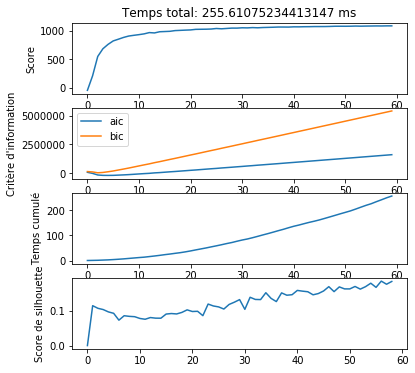

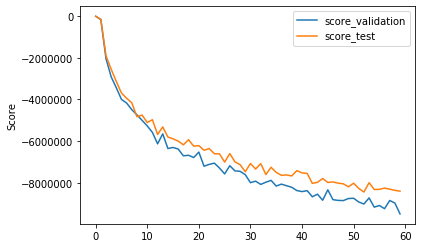

In [91]:
list_silhouette = [0] + [silhouette_score(X_pca, gm.predict(X_pca)) for gm in list_gm[2:]]

plt.figure(figsize=(6,6))
plt.xlabel("k")
plt.subplot(411)
plt.ylabel("Score")
plt.title(f"Temps total: {cum_time[-1]} ms")
plt.plot(list_score, label="score_train")
plt.subplot(412)
plt.ylabel("Critère d'information")
plt.plot(list_aic, label="aic")
plt.plot(list_bic, label="bic")
plt.legend()
plt.subplot(413)
plt.ylabel("Temps cumulé")
plt.plot(cum_time)
plt.subplot(414)
plt.ylabel("Score de silhouette")
plt.plot(list_silhouette)
plt.show()
# Nous avons l'impression que les critères BIC, AIC sont minimaux pour de faibles valeurs de k ~ 2 ou 3. 
# Le score devient meilleur au fur et à mesure que k devient grand, k > 30 on a un plateau
# Pourtant, quand on regarde le score sur le jeu de validation et de test, le score est bien meilleur quand k faible, ~2 ou 3
# Le score de silhouette augmente quand k augmente, mais on peut remarquer qu'il y a un break soudain à k ~2 ou 3
plt.figure()
plt.ylabel("Score")
plt.plot(list_score_validation, label="score_validation")
plt.plot(list_score_test, label="score_test")
plt.legend()

<Figure size 432x288 with 0 Axes>

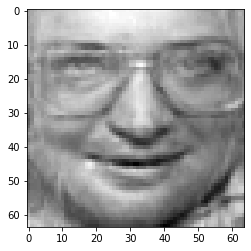

<Figure size 432x288 with 0 Axes>

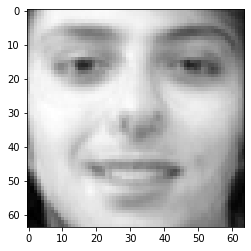

<Figure size 432x288 with 0 Axes>

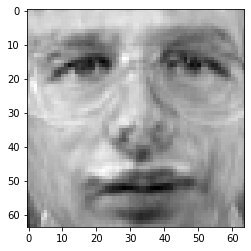

<Figure size 432x288 with 0 Axes>

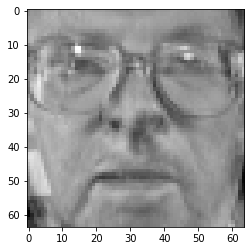

<Figure size 432x288 with 0 Axes>

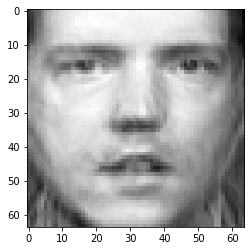

In [44]:
# Génératione et visualisation
gm = list_gm[40]

def visualize_sample(x_samples):
    inverse_matrix = pca.inverse_transform(x_samples)
    for inverse in inverse_matrix:
        plt.figure()
        X_to_img(inverse)

X_sample, y_sample = gm.sample(n_samples = 5)
visualize_sample(X_sample)

# Détection d'anomalie

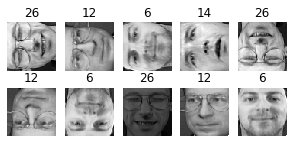

In [46]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
darkened = darkened.reshape(-1, 64*64)
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])


def plot_faces(faces, labels, n_cols=5):
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face.reshape(64, 64), cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()
    
plot_faces(X_bad_faces, y_bad)

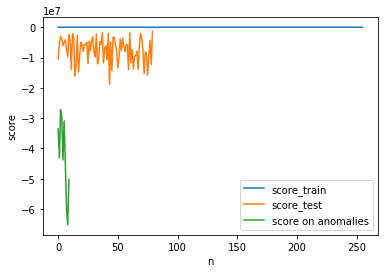

In [51]:
X_bad_faces_pca = pca.transform(X_bad_faces)
good_scores_train = gm.score_samples(X_pca)
# good_scores_validation = gm.score_samples(pca.transform(X_validation))
good_scores_test = gm.score_samples(pca.transform(X_test))

bad_scores = gm.score_samples(X_bad_faces_pca)

plt.figure()
plt.xlabel("n")
plt.ylabel("score")
plt.plot(good_scores_train, label="score_train")
plt.plot(good_scores_test, label="score_test")
plt.plot(bad_scores, label="score on anomalies")
plt.legend()

# Nous pouvons voir que le score est très faible par rapport aux autres scores. Même bien inférieur à ceux du jeu de test. 

In [75]:
# Détection d'anomalies par PCA
from sklearn.metrics import mean_squared_error

def reconstructing_error(X_reduced, X_train, pca):
    X_reconstructed = pca.inverse_transform(X_reduced)
    return mean_squared_error(X_reconstructed, X_train)

error_train = reconstructing_error(X_pca, X_train, pca)
error_test = reconstructing_error(pca.transform(X_test), X_test, pca)
error_anomalies = reconstructing_error(X_bad_faces_pca, X_bad_faces, pca)

print(f"Erreurs de reconstruction [train, test, anomalies]: {[error_train, error_test, error_anomalies]}")
# Nous voyons que l'erreur de reconstruction est bien supérieur pour les anomalies. Toutefois, celle pour le jeu de test n'en est pas loin non plus, ce qui n'est pas très rassurant

Erreurs de reconstruction [train, test, anomalies]: [0.000186705, 0.0020677778, 0.006343339]


# Kmeans et DBSCAN

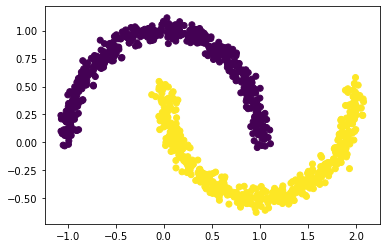

In [12]:
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans, DBSCAN
X_train, y_train = make_moons(n_samples=1000, noise=0.05)
plt.scatter(X_train[:, 0], X_train[:,1], c=y_train)


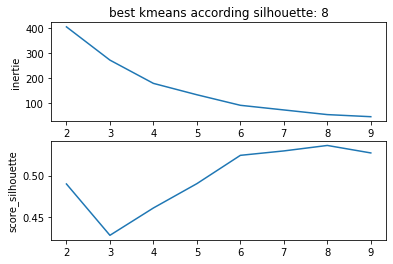

In [21]:
from sklearn.metrics import silhouette_score

list_k = []
list_kmeans = []
list_inertie = []
list_silhouette = []
for k in range(2, 10):
    kmeans = KMeans(n_init=10, n_clusters=k)
    kmeans.fit(X_train)
    list_k.append(k)
    list_kmeans.append(kmeans)

    inertie = kmeans.inertia_
    silhouette = silhouette_score(X_train, kmeans.labels_)
    list_inertie.append(inertie)
    list_silhouette.append(silhouette)

from sklearn.metrics import accuracy_score

best_idx = np.argmax(list_silhouette)
best_kmeans = list_kmeans[np.argmax(list_silhouette)]
best_centroides = best_kmeans.cluster_centers_

plt.figure()
plt.subplot(211)
plt.title(f"best kmeans according silhouette: {best_idx + 2}")
plt.xlabel("k")
plt.ylabel("inertie")
plt.plot(list_k, list_inertie)
plt.subplot(212)
plt.ylabel("score_silhouette")
plt.plot(list_k, list_silhouette)
plt.show()

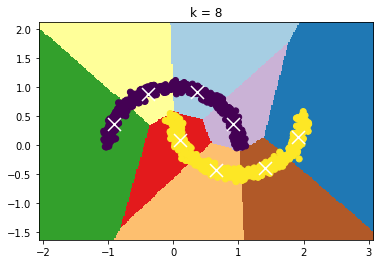

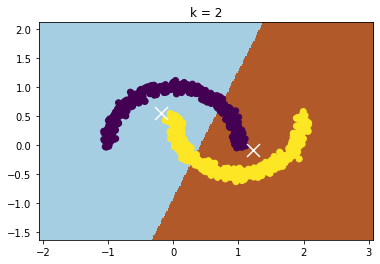

In [39]:
# Plot the decision boundary. For that, we will assign a color to each

def display_borders(kmeans):
    centroides = kmeans.cluster_centers_
    k = centroides.shape[0]
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.clf()
    plt.title(f"k = {k}")
    plt.imshow(Z, interpolation="nearest",
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            cmap=plt.cm.Paired, aspect="auto", origin="lower")

    plt.scatter(X_train[:, 0], X_train[:,1], c=y_train)
    plt.scatter(centroides[:, 0], centroides[:, 1], marker="x", s=169, linewidths=3,
                color="w", zorder=10)
display_borders(best_kmeans)
display_borders(list_kmeans[0])

# Nous voyons que Kmeans a dû mal avec les clusters qui ne sont pas sphériques ou ellipsoïdaux.

<Figure size 432x288 with 0 Axes>

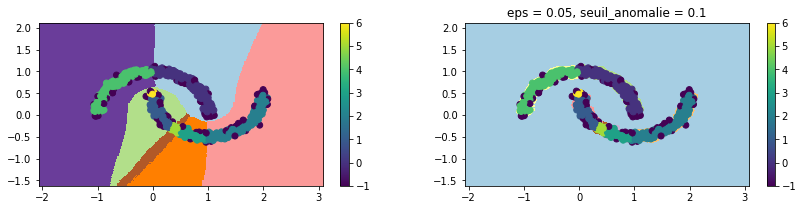

<Figure size 432x288 with 0 Axes>

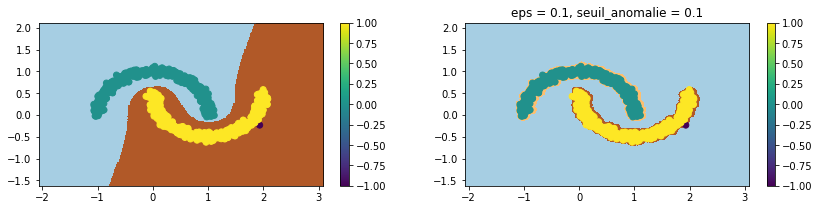

<Figure size 432x288 with 0 Axes>

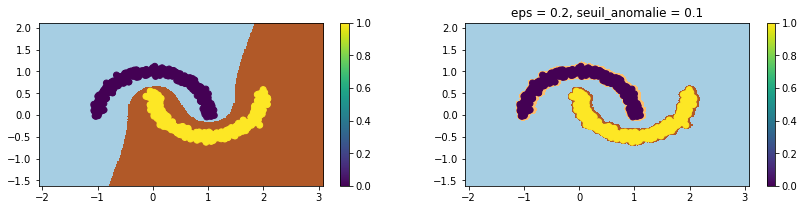

In [77]:

from sklearn.neighbors import KNeighborsClassifier

def visualize_dbscan(list_eps, seuil_anomalie = 0.1):
    for eps in list_eps:
        dbscan = DBSCAN(eps=eps, min_samples=5)
        knn = KNeighborsClassifier(n_neighbors=50)
        dbscan.fit(X_train)
        # .components_ sont les instances core
        knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

        plt.figure()
        h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
        y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Obtain labels for each point in mesh. Use last trained model.
        X_new = np.c_[xx.ravel(), yy.ravel()]
        Z = knn.predict(X_new)
        # ATTENTION, ici, KNN ne prédit pas les anomalies. On peut mettre un seuil pour les anomalies
        y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
        idx = y_dist > seuil_anomalie
        # Z[idx[:,0]] = -1

        Z_anomalie = np.copy(Z)
        Z_anomalie[idx[:,0]] = -1


        plt.figure(figsize=(14,3))
        plt.subplot(121)
        def plot_subplot(Z, with_anomalie=False):
            Z = Z.reshape(xx.shape)
            # plt.clf()
            plt.title(f"k = {k}")
            plt.imshow(Z, interpolation="nearest",
                    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                    cmap=plt.cm.Paired, aspect="auto", origin="lower")
            # plt.figure()
            plt.title(f"eps = {eps}" + f", seuil_anomalie = {seuil_anomalie}" if with_anomalie else "")
            plt.scatter(X_train[:, 0], X_train[:,1], c=dbscan.labels_)
            # plt.scatter(X_train[:, 0], X_train[:,1])
            plt.colorbar()
        plot_subplot(Z)
        plt.subplot(122)
        plot_subplot(Z_anomalie, with_anomalie=True)

visualize_dbscan([0.05, 0.1, 0.2])

# Nous voyons que DBSCAN arrive mieux à trouver les clusters de formes un peu plus spéciales
